In [1]:
using Images

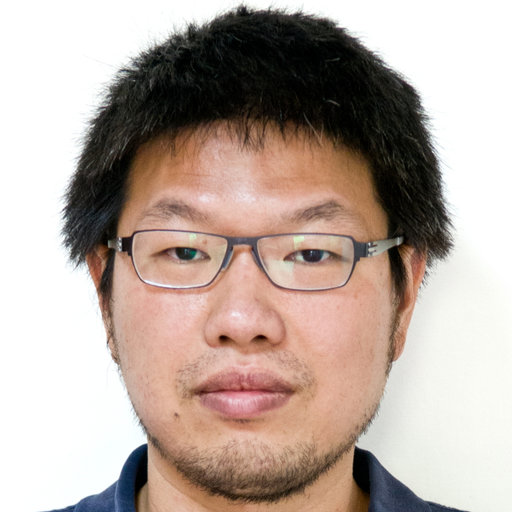

In [2]:
img=load("Lin.jpg")

In [3]:
B=zeros(size(img,1),size(img,2))
for i=1:size(img,1)
    for j=1:size(img,2)
        if rand() >=0.8
            B[i,j] = 0
        elseif rand() <= 0.2
            B[i,j]=1
        else
            B[i,j]=3
        end
    end
end

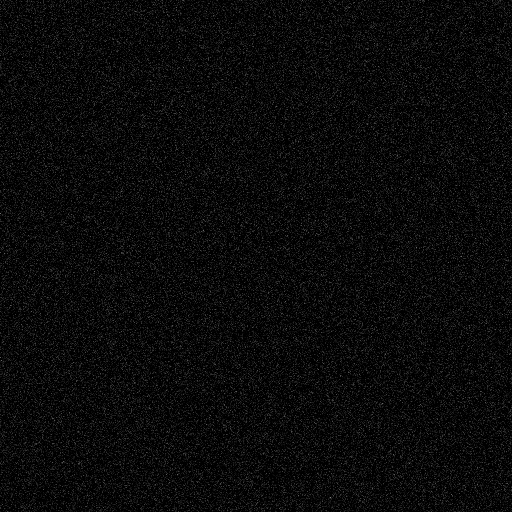

In [4]:
C=Gray.(sqrt(0.01)*(randn(size(img,1),size(img,2))))

In [5]:
chimg=copy(channelview(img));
for k=1:3
    for i=1:size(img,1)
        for j=1:size(img,2)
            if B[i,j]==0
                chimg[k,i,j]=B[i,j];
            end
            if B[i,j]==1
                chimg[k,i,j]=B[i,j];
            end
        end
    end
end

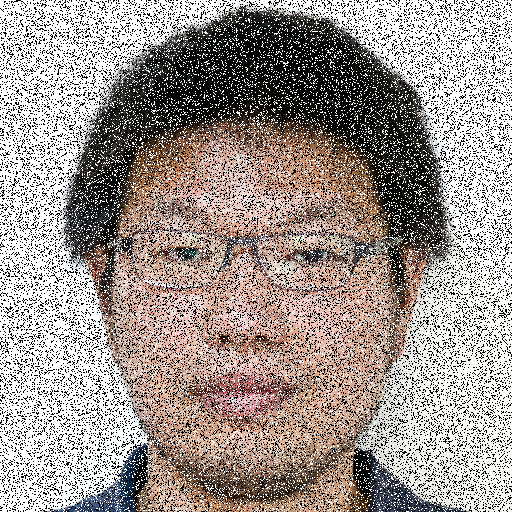

In [6]:
img3 = colorview(RGB,chimg)

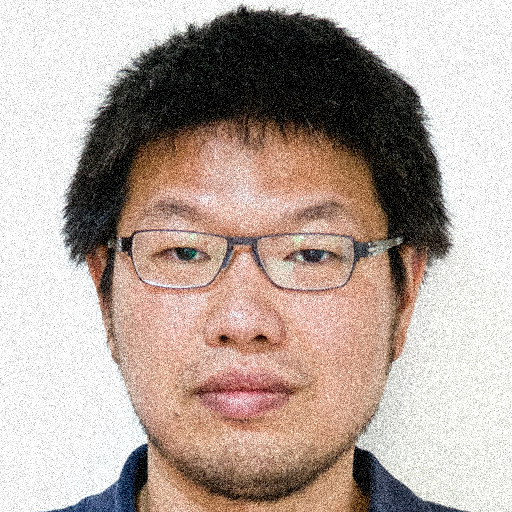

In [7]:
img4 = img.+C

In [8]:
chimg3=channelview(img3);
chimg4=channelview(img4);

In [9]:
imgB1 = mapwindow(median!,chimg3[1,:,:], (7,7));
imgB2 = mapwindow(median!,chimg3[2,:,:], (7,7));
imgB3 = mapwindow(median!,chimg3[3,:,:], (7,7));
imgB=zeros(3,512,512);
imgB[1,:,:]=imgB1;
imgB[2,:,:]=imgB2;
imgB[3,:,:]=imgB3;

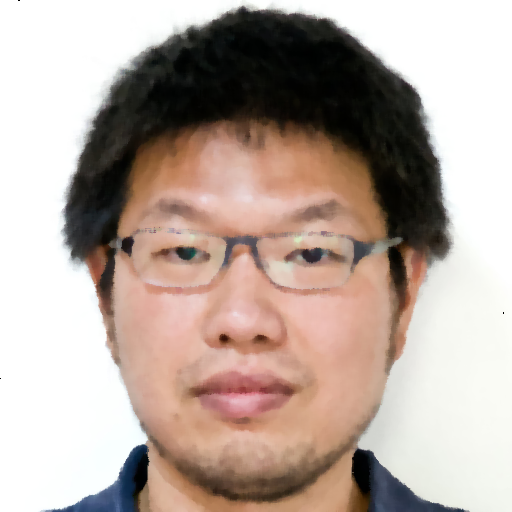

In [10]:
imgBc=colorview(RGB,imgB)

In [11]:
imgC1 = mapwindow(median!,chimg4[1,:,:], (7,7));
imgC2 = mapwindow(median!,chimg4[2,:,:], (7,7));
imgC3 = mapwindow(median!,chimg4[3,:,:], (7,7));
imgC=zeros(3,512,512);
imgC[1,:,:]=imgC1;
imgC[2,:,:]=imgC2;
imgC[3,:,:]=imgC3;

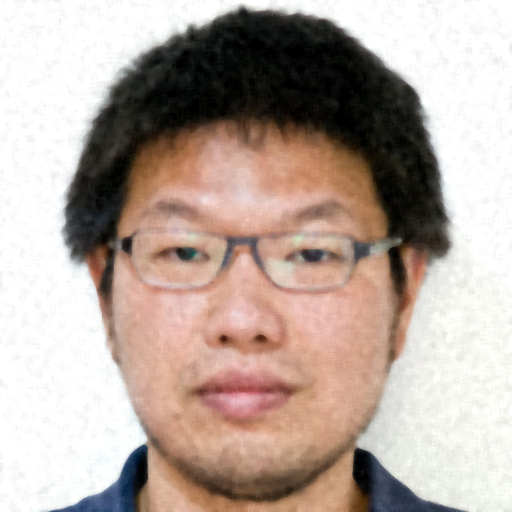

In [12]:
imgCc=colorview(RGB,imgC)

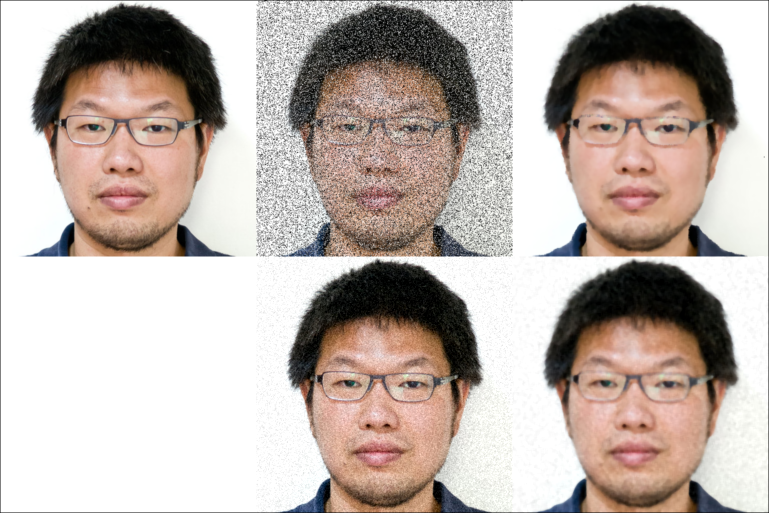

In [13]:
acompare=ones(3,1024,1536);
compare=colorview(RGB,acompare);
compare[1:512,1:512]=img;
compare[1:512,513:1024]=img3;
compare[513:1024,513:1024]=img4;
compare[1:512,1025:1536]=imgBc;
compare[513:1024,1025:1536]=imgCc;
compare

In [14]:
save("img3.png",img3);
save("img4.png",img4);
save("imgBc.png",imgBc);
save("imgCc.png",imgCc);
save("compare.png",compare);

Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.


From here we start to use the Primal-Dual algorithm to solve the problem, which can be founnd http://znah.net/rof-and-tv-l1-denoising-with-primal-dual-algorithm.html. This is just a Julia revision of the code.

In [15]:
function nabla(x)
    G=zeros(size(x,1),size(x,2),2);
    G[1:size(x,1),1:size(x,2)-1,1]-=x[1:size(x,1),1:size(x,2)-1]
    G[1:size(x,1),1:size(x,2)-1,1]+=x[1:size(x,1),2:size(x,2)]
    G[1:size(x,1)-1,1:size(x,2),2]-=x[1:size(x,1)-1,1:size(x,2)]
    G[1:size(x,1)-1,1:size(x,2),2]+=x[2:size(x,2),1:size(x,2)]
    return G
end

nabla (generic function with 1 method)

In [16]:
function nablaT(G)
    x=zeros(size(G,1),size(G,2))
    x[1:size(x,1),1:size(x,2)-1]-=G[1:size(x,1),1:size(x,2)-1,1]
    x[1:size(x,1),2:size(x,2)]+=G[1:size(x,1),1:size(x,2)-1,1]
    x[1:size(x,1)-1,1:size(x,2)]-=G[1:size(x,1)-1,1:size(x,2),2]
    x[2:size(x,2),1:size(x,2)]+=G[1:size(x,1)-1,1:size(x,2),2]
    return x
end

nablaT (generic function with 1 method)

In [17]:
function anorm(A)
    C=A.*A
    return sqrt.(C[:,:,1]+C[:,:,2])
end

anorm (generic function with 1 method)

In [18]:
function calc_energy_TVL1(X, observation, clambda)
    Ereg=0.
    a = anorm(nabla(X))
    for i in a
        Ereg+=i
    end
    Edata=0.;
    for i=1:size(X,1)
        for j=1:size(X,2)
            Edata=Edata+abs(X[i,j]-observation[i,j])
        end
    end
    Edata=Edata*clambda
    return Ereg + Edata
end

calc_energy_TVL1 (generic function with 1 method)

In [19]:
lambda_TVL1 = 1.0

1.0

In [20]:
function project_nd(P, r)
    nP = max.(1.0, anorm(P)/r)
    return P ./ nP
end

project_nd (generic function with 1 method)

In [21]:
function shrink_1d(X, F, step)
    return X .+ clamp.(F - X, -step, step)
end

shrink_1d (generic function with 1 method)

In [22]:
function solve_TVL1(img, clambda, iter_n=101)
    # setting step sizes and other params
    L2 = 8.0
    tau = 0.02
    sigma = 1.0 / (L2*tau)
    theta = 1.0

    X = copy(img)
    P = nabla(X)
    for i in 1:iter_n
        P = project_nd( P .+ sigma.*nabla(X), 1.0 )
        X1 = shrink_1d(X - tau.*nablaT(P), img, clambda*tau)
        X = X1 .+ theta * (X1 - X)
        if i % 10 == 0
            print(calc_energy_TVL1(X, img, clambda)," ");
        end
    end
    return X
end

solve_TVL1 (generic function with 2 methods)

In [23]:
chimg3=channelview(img3);

In [24]:
T1=solve_TVL1(chimg3[1,:,:],1,101);
T2=solve_TVL1(chimg3[2,:,:],1,101);
T3=solve_TVL1(chimg3[3,:,:],1,101);

71703.00793285912 59852.27274857409 58284.76019111236 56389.99188655206 56168.68308888502 56466.62145139735 55429.67682836599 55729.53629537826 55866.721101825446 55134.988187912546 69233.66514355235 58938.02197485113 57485.03288268668 55587.75946895043 55430.21306554292 55812.129006514864 54721.59149740253 55071.00711885427 55235.02606882713 54451.86940001171 68637.39044613647 58498.086032857274 57048.03104752987 55199.46265795851 55046.414598979296 55396.48087902747 54325.20282319035 54659.56796891185 54807.63968559344 54037.94178180031 

In [25]:
imgT=zeros(3,512,512);
imgT[1,:,:]=T1;
imgT[2,:,:]=T2;
imgT[3,:,:]=T3;

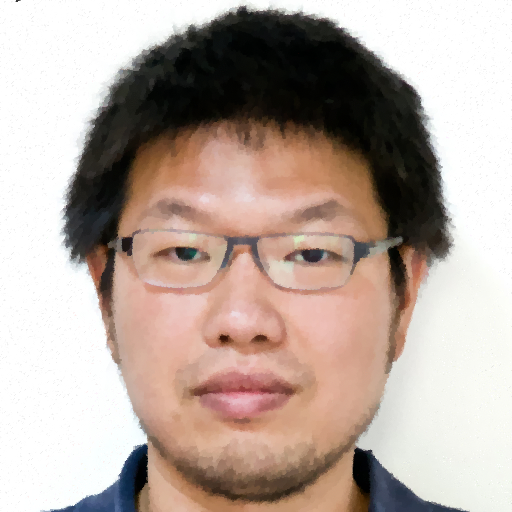

In [26]:
imgTc=colorview(RGB,imgT)

In [27]:
chimg4=channelview(img4);
V1=solve_TVL1(chimg4[1,:,:],1,101);
V2=solve_TVL1(chimg4[2,:,:],1,101);
V3=solve_TVL1(chimg4[3,:,:],1,101);

32215.092159811888 29247.556104358657 27787.543406904475 26848.990793963058 26228.031684682555 25748.046168684003 25400.559230465835 25106.668184060723 24884.693577609567 24696.589256783314 32158.314928922853 29185.752768345883 27709.16915618853 26779.065994774803 26153.288978767792 25669.438993902197 25324.38020289055 25036.444586398065 24814.308890507862 24629.77695346369 32083.860856946747 29088.349508265503 27606.495379335465 26685.437645772825 26049.587048020734 25570.33778885638 25226.621301864947 24938.615221415377 24714.211999464645 24533.42025634459 

In [28]:
imgV=zeros(3,512,512);
imgV[1,:,:]=V1;
imgV[2,:,:]=V2;
imgV[3,:,:]=V3;

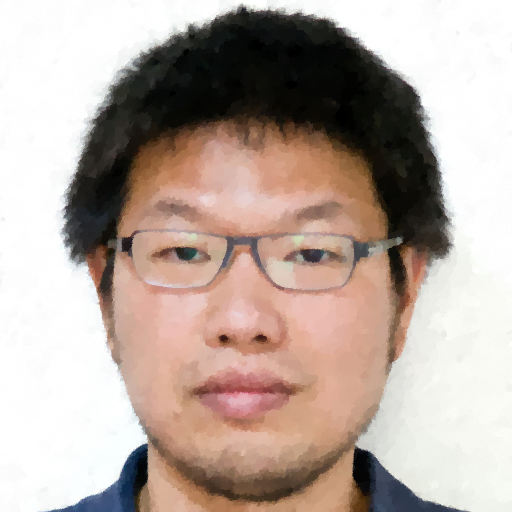

In [29]:
imgVc=colorview(RGB,imgV)

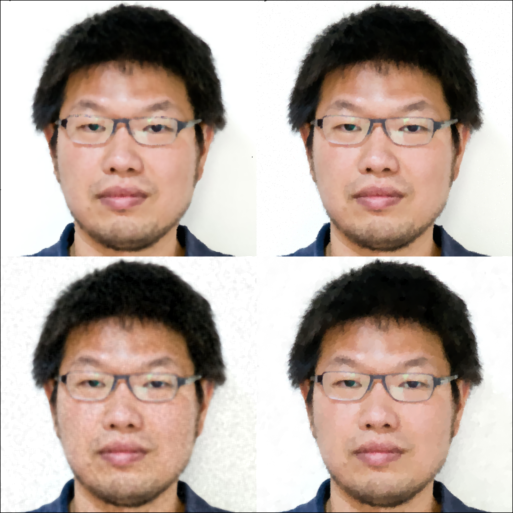

In [30]:
acompare2=ones(3,1024,1024);
compare2=colorview(RGB,acompare2);
compare2[1:512,1:512]=imgBc;
compare2[513:1024,1:512]=imgCc;
compare2[1:512,513:1024]=imgTc;
compare2[513:1024,513:1024]=imgVc;
compare2

In [31]:
save("imgTc.png",imgTc);
save("imgVc.png",imgVc);
save("compare2.png",compare2);

Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.
Try `map(clamp01nan, img)` to clamp values to a valid range.
